In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

from utils import (
    detrend, monthly_anomalies, interp_coords,
    standardize, corr_with_ttest
)

In [2]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr/')

In [3]:
eq = dict(lat=0)
eq_band = dict(lat=slice(-5, 5))
nino3_region = dict(lon=slice(210, 270), **eq_band)
nino4_region = dict(lon=slice(160, 210), **eq_band)
tpart= dict(time=slice('1979-01','2019-12'))

## Prepare Data
### Nemo SSH 

In [4]:
ssh_mon_anom = detrend(
    monthly_anomalies(
        t_grid_file.sossheig.sel(**eq_band, **tpart)
    ).compute()
)
ssh_eq = ssh_mon_anom.sel(**eq)

### D20 

In [5]:
d20_mon_anom = detrend(
    monthly_anomalies(
        (-1) * t_grid_file.d20.sel(**eq_band, **tpart)
    ).fillna(0.)
    .compute()
)

d20_eq = d20_mon_anom.sel(**eq)

### NTI

In [6]:
nti_n4=(
    standardize(ssh_mon_anom) + standardize(d20_mon_anom)
).sel(
    **nino4_region
).mean(['lat','lon']).rename('nti_n4').compute()

### SST 

In [7]:
sst_mon_anom = monthly_anomalies(
    t_grid_file.sosstsst.sel(**tpart)
)

n3 = sst_mon_anom.sel(
    **nino3_region
).mean(('lon', 'lat')).rename('sst_n3')

n4 = sst_mon_anom.sel(
    **nino4_region
).mean(('lon', 'lat')).rename('sst_n3')

### From Ashok2007 EMI: CP 

In [8]:
a_region = dict(lon=slice(165, 220), lat=slice(-10, 10))
b_region = dict(lon=slice(250, 290), lat=slice(-15, 5))
c_region = dict(lon=slice(125, 145), lat=slice(-10, 20))

In [9]:
aindex = sst_mon_anom.sel(**a_region).mean(('lon', 'lat'))
bindex = sst_mon_anom.sel(**b_region).mean(('lon', 'lat'))
cindex = sst_mon_anom.sel(**c_region).mean(('lon', 'lat'))
emi = aindex - 0.5 * bindex - 0.5 * cindex

### From Ren and Jin(2010) ict:EP / iwp:CP 

In [10]:
aa = n3 * n4
alpha = np.where(aa > 0, 0.4, 0)
Nwp = n4 - alpha * n3

## 2.detrend and correlation

In [11]:
ds = xr.Dataset(
    {"nti": nti_n4, "n4": n4, "emi": emi, "Nwp": Nwp}
).compute()

In [12]:
ds_dt = detrend(ds)

In [13]:
def get_test(var1, var2, sig=0.99):
    corr, c_low, c_up = corr_with_ttest(
        var1, var2, sig=sig,
        t_bound_kwargs=dict(dim=[])
    )
    ttest = corr > c_up
    return corr.values, c_up.values, ttest.values

In [14]:
def produce_table(ds):
    varname_map = dict(
        n4="SST\t", nti="NEMO-NTI", Nwp="N_wp\t", emi="EMI\t"
    )
    print(
        f"\t\t{varname_map['nti']}\t{varname_map['Nwp']}\t{varname_map['emi']}"
    )
    for v1 in ("n4", "nti", "Nwp"):
        res = []
        for v2 in ("nti", "Nwp", "emi"):
            corr, _, _ = get_test(ds[v1], ds[v2])
            res.append(corr)
        print(f"{varname_map[v1]}\t{res[0]:.2f}\t\t{res[1]:.2f}\t\t{res[2]:.2f}")

In [15]:
produce_table(ds_dt)

		NEMO-NTI	N_wp		EMI	
SST		0.87		0.88		0.90
NEMO-NTI	1.00		0.75		0.75
N_wp		0.75		1.00		0.94


## Based on Hadley data 

In [16]:
ssth_all = (
    xr.open_dataset('data/HadISST_sst.nc')
    .sst[:,::-1,:]
    .rename({'latitude':'lat', 'longitude':'lon'})
)
ssth_a = monthly_anomalies(
    ssth_all
    .where(ssth_all > -800)
    .sel(**tpart)
    .assign_coords({'lon': (ssth_all.lon + 360) % 360.})
    .reindex(lon=np.arange(360)+0.5)
)

In [17]:
h_n3 = ssth_a.sel(**nino3_region).mean(('lon', 'lat'))
h_n4 = ssth_a.sel(**nino4_region).mean(('lon', 'lat'))

### From Ashok2007 EMI: CP 

In [18]:
h_aindex = ssth_a.sel(**a_region).mean(('lon', 'lat'))
h_bindex = ssth_a.sel(**b_region).mean(('lon', 'lat'))
h_cindex = ssth_a.sel(**c_region).mean(('lon', 'lat'))
h_emi = h_aindex - 0.5 * h_bindex - 0.5 * h_cindex

#### From Ren and Jin(2010) ict:EP / iwp:CP 

In [19]:
h_aa = h_n3 * h_n4
h_alpha = np.where(h_aa > 0, 0.4, 0)
h_Nwp = h_n4 - h_alpha * h_n3

### detrend and correlation

In [20]:
h_ds = xr.Dataset({"n4": h_n4, "emi": h_emi, "Nwp": h_Nwp, "nti": nti_n4}).compute()

In [21]:
h_ds_dt = detrend(h_ds)

In [22]:
produce_table(h_ds_dt)

		NEMO-NTI	N_wp		EMI	
SST		0.86		0.85		0.77
NEMO-NTI	1.00		0.74		0.62
N_wp		0.74		1.00		0.93


#### Plot 

In [23]:
nemo = xr.concat(
    (ds_dt.n4,ds_dt.emi,ds_dt.Nwp,ds_dt.nti),
    dim=xr.DataArray(
        ["sst", "emi","Nwp", "nti"],
        dims=("variable",),
        name="variable")
).rename("nemo").compute()

In [24]:
nemo2 = xr.concat(
    (ds_dt.n4,ds_dt.emi,ds_dt.Nwp,ds_dt.nti),
    dim=xr.DataArray(
        ["sst", "emi","Nwp", "nti"],
        dims=("variable2",),
        name="variable2")
).rename("nemo2").compute()

Text(0.5, 1.0, 'Correlation')

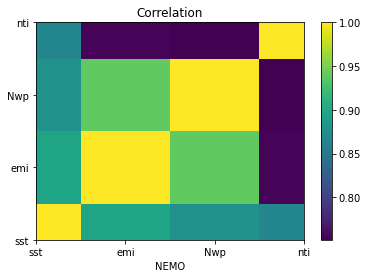

In [25]:
xr.corr(nemo2,nemo, dim="time").plot()
plt.xticks([0, 1, 2, 3], [ "sst", "emi", "Nwp", "nti"]);
plt.yticks([0, 1, 2, 3], [ "sst", "emi", "Nwp", "nti"]);
plt.ylabel('')
plt.xlabel('NEMO')
plt.title('Correlation')

In [26]:
hadley = xr.concat(
    (h_ds_dt.n4,h_ds_dt.emi,h_ds_dt.Nwp,ds_dt.nti),
    dim=xr.DataArray(
        ["sst", "emi","Nwp", "nti"],
        dims=("vari",),
        name="vari")
).rename("hadley").compute()

In [27]:
hadley2 = xr.concat(
    (h_ds_dt.n4,h_ds_dt.emi,h_ds_dt.Nwp,ds_dt.nti),
    dim=xr.DataArray(
        ["sst", "emi","Nwp", "nti"],
        dims=("vari2",),
        name="vari2")
).rename("hadley2").compute()

Text(0.5, 1.0, 'Correlation')

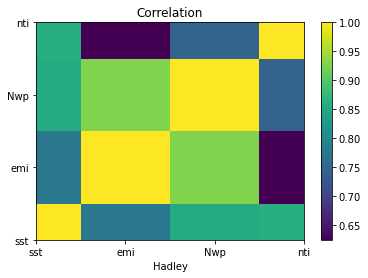

In [28]:
xr.corr(hadley,hadley2, dim="time").plot()
plt.xticks([0, 1, 2, 3], [ "sst", "emi", "Nwp", "nti"]);
plt.yticks([0, 1, 2, 3], ["sst", "emi", "Nwp", "nti"]);
plt.ylabel('')
plt.xlabel('Hadley')
plt.title('Correlation')

Text(0.5, 1.0, 'Correlation')

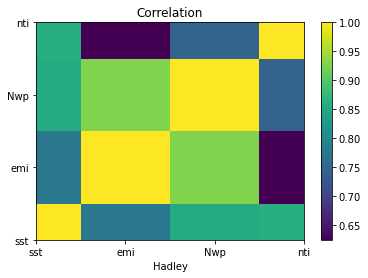

In [29]:
xr.corr(hadley,hadley2, dim="time").plot()
plt.xticks([0, 1, 2, 3], [ "sst", "emi", "Nwp", "nti"]);
plt.yticks([0, 1, 2, 3], ["sst", "emi", "Nwp", "nti"]);
plt.ylabel('')
plt.xlabel('Hadley')
plt.title('Correlation')